In [1]:
# Install required packages
!pip install wget
!pip install open3d
!pip install ultralytics
!pip install matplotlib
!pip install deep-sort-realtime
!pip install torchreid

In [2]:
import os
import sys
import shutil
import cv2
import numpy as np
import torch
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

2025-04-25 18:35:55.580342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745606155.602601     147 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745606155.609387     147 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Clone UFLD repository
os.system("git clone https://github.com/ibaiGorordo/Ultrafast-Lane-Detection-Inference-Pytorch-.git")
print("✅ Cloned Ultrafast-Lane-Detection repository")

# Clear module cache
for module in list(sys.modules.keys()):
    if "ultrafastLaneDetector" in module or "model" in module:
        del sys.modules[module]
print("✅ Cleared ultrafastLaneDetector and model module cache")

✅ Cloned Ultrafast-Lane-Detection repository
✅ Cleared ultrafastLaneDetector and model module cache


fatal: destination path 'Ultrafast-Lane-Detection-Inference-Pytorch-' already exists and is not an empty directory.


In [4]:
# Define paths
repo_path = "/kaggle/working/Ultrafast-Lane-Detection-Inference-Pytorch-"
detector_path = os.path.join(repo_path, "ultrafastLaneDetector")
model_path = os.path.join(detector_path, "model")
simple_file_path = "/kaggle/working/ultrafastLaneDetector.py"
model_file_path = "/kaggle/working/model.py"

In [5]:
# Define paths
detector_path = os.path.join(repo_path, "ultrafastLaneDetector")
model_path = os.path.join(detector_path, "model")
simple_file_path = os.path.join(detector_path, "ultrafastLaneDetector.py")
model_file_path = os.path.join(model_path, "model.py")

In [6]:
model_content = """
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class parsingNet(nn.Module):
    def __init__(self, pretrained=False, backbone='18', cls_dim=(201, 18, 4), use_aux=False):
        super(parsingNet, self).__init__()
        self.cls_dim = cls_dim
        self.use_aux = use_aux
        
        if backbone == '18':
            self.model = models.resnet18(pretrained=pretrained)
        else:
            raise NotImplementedError(f"Backbone {backbone} not supported")
        
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Identity()
        
        self.cls = nn.Sequential(
            nn.Linear(1800, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, cls_dim[0] * cls_dim[1] * cls_dim[2])
        )
        
        self.pool = nn.Conv2d(512, cls_dim[2], kernel_size=1)
        
    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        
        target_features = 1800
        channels = x.size(1)
        spatial_size = int((target_features / channels) ** 0.5) + 1
        if spatial_size < 1:
            spatial_size = 1
        x = F.adaptive_avg_pool2d(x, (spatial_size, spatial_size))
        
        x = x.view(x.size(0), -1)
        if x.size(1) > target_features:
            x = x[:, :target_features]
        elif x.size(1) < target_features:
            x = F.pad(x, (0, target_features - x.size(1)))
        
        cls_out = self.cls(x)
        cls_out = cls_out.view(-1, self.cls_dim[2], self.cls_dim[1], self.cls_dim[0])
        
        if self.use_aux:
            pool_out = self.pool(x.view(x.size(0), 512, 1, 1))
            return cls_out, pool_out
        return cls_out
"""

# Write updated ultrafastLaneDetector.py
ufld_content = """
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from ultrafastLaneDetector.model import parsingNet

class ModelType:
    CULANE = 0
    TUSIMPLE = 1

class ModelConfig:
    def __init__(self):
        self.num_points = 18
        self.num_lanes = 4
        self.prob_th = 0.3
        self.img_w = 1280
        self.img_h = 720
        self.griding_num = 200
        self.backbone = '18'
        self.ort = False
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class UltrafastLaneDetector:
    def __init__(self, model_path, model_type=0, use_gpu=True):
        self.model_type = model_type
        self.cfg = ModelConfig()
        self.model = parsingNet(
            pretrained=False,
            backbone=self.cfg.backbone,
            cls_dim=(self.cfg.griding_num + 1, self.cfg.num_points, self.cfg.num_lanes),
            use_aux=False
        ).to(self.cfg.device)
        
        state_dict = torch.load(model_path, map_location=self.cfg.device)
        if 'model' in state_dict:
            state_dict = state_dict['model']
            print(f"✅ Loaded nested state_dict['model'] with keys: {list(state_dict.keys())[:10]}")
        elif all(k.startswith('model.') for k in state_dict.keys()):
            state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
            print(f"✅ Stripped 'model.' prefix from state_dict keys: {list(state_dict.keys())[:10]}")
        
        try:
            self.model.load_state_dict(state_dict, strict=False)
            print("✅ Successfully loaded state_dict (strict=False)")
        except Exception as e:
            print(f"❌ Failed to load state_dict: {e}")
            raise
        self.model.eval()

    def detect_lanes(self, image, draw_points=True):
        input_tensor = self.prepare_input(image)
        output = self.inference(input_tensor)
        self.lanes_points, self.lanes_detected = self.process_output(output, self.cfg)
        output_img = self.draw_lanes(image, self.lanes_points, self.lanes_detected, draw_points)
        fps = -1
        return output_img, fps

    def prepare_input(self, img):
        if img.shape[:2] != (self.cfg.img_h, self.cfg.img_w):
            img = cv2.resize(img, (self.cfg.img_w, self.cfg.img_h))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.transpose((2, 0, 1)).astype(np.float32) / 255.0
        img = torch.from_numpy(img).float().to(self.cfg.device)
        return img.unsqueeze(0)

    def inference(self, input_tensor):
        with torch.no_grad():
            output = self.model(input_tensor)
        return output

    def process_output(self, output, cfg):
        processed_output = output[0].reshape(-1, cfg.num_points * 3)
        lanes_points = []
        lanes_detected = []

        for lane_num in range(cfg.num_lanes):
            lane_points = []
            lane_detected = False
            scores = F.softmax(processed_output[lane_num * cfg.num_points: (lane_num + 1) * cfg.num_points, :2], dim=1)[:, 1]
            ranges = processed_output[lane_num * cfg.num_points: (lane_num + 1) * cfg.num_points, 2]
            max_idx = torch.argmax(scores)
            if scores[max_idx] > cfg.prob_th:
                lane_detected = True
                selected_indices = torch.where(scores >= cfg.prob_th)[0]
                for idx in selected_indices:
                    x = (ranges[idx] * cfg.img_w).cpu().numpy()
                    y = ((cfg.num_points - idx - 1) * cfg.img_h / (cfg.num_points - 1)).cpu().numpy()
                    lane_points.append([float(x), float(y)])
            lanes_points.append(lane_points)
            lanes_detected.append(lane_detected)
            print(f"Lane {lane_num + 1}: Detected={lane_detected}, Points={len(lane_points)}")

        return lanes_points, np.array(lanes_detected)

    def draw_lanes(self, img, lanes_points, lanes_detected, draw_points=True):
        output_img = img.copy()
        lane_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
        for lane_num, (lane_points, lane_detected) in enumerate(zip(lanes_points, lanes_detected)):
            if lane_detected:
                for point in lane_points:
                    if draw_points:
                        cv2.circle(output_img, (int(point[0]), int(point[1])), 3, lane_colors[lane_num], -1)
        return output_img

    def get_ego_lane_index(self):
        return 1
"""

try:
    os.makedirs(model_path, exist_ok=True)
    with open(model_file_path, "w") as f:
        f.write(model_content)
    with open(simple_file_path, "w") as f:
        f.write(ufld_content)
    print(f"✅ Wrote model.py to {model_file_path}")
    print(f"✅ Wrote ultrafastLaneDetector.py to {simple_file_path}")
except Exception as e:
    print(f"❌ Failed to write files: {e}")

# Add repo path to sys.path
sys.path.append(repo_path)
try:
    from ultrafastLaneDetector import UltrafastLaneDetector, ModelType
    from ultrafastLaneDetector.model import parsingNet
    print("✅ Successfully imported UltrafastLaneDetector and parsingNet")
except Exception as e:
    print(f"❌ Import failed: {e}")

# Debug state_dict
ufld_model_path = "/kaggle/input/culane/pytorch/default/1/culane_18.pth"
try:
    state_dict = torch.load(ufld_model_path, map_location='cpu')
    print(f"Top-level state_dict keys: {list(state_dict.keys())[:10]}")
    if 'model' in state_dict:
        nested_dict = state_dict['model']
        print(f"Nested state_dict['model'] keys: {list(nested_dict.keys())[:10]}")
        print(f"cls.0.weight shape: {nested_dict.get('cls.0.weight').shape}")
        print(f"cls.2.weight shape: {nested_dict.get('cls.2.weight').shape}")
        print(f"pool.weight shape: {nested_dict.get('pool.weight').shape}")
    else:
        print("❌ No 'model' key in state_dict")
except Exception as e:
    print(f"❌ Failed to inspect state_dict: {e}")

# Define lane colors
lane_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]

# Load UFLD model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not os.path.exists(ufld_model_path):
    raise FileNotFoundError(f"❌ culane_18.pth not found at {ufld_model_path}")
try:
    lane_detector = UltrafastLaneDetector(ufld_model_path, model_type=ModelType.CULANE, use_gpu=(device.type == "cuda"))
    lane_detector.model.to(device)
    print("✅ UFLD Model loaded")
except Exception as e:
    print(f"❌ Failed to load UFLD model: {e}")
    lane_detector = None

# Save UFLD model
if lane_detector:
    saved_model_path = "/kaggle/working/ulfd_culane_18.pth"
    try:
        torch.save(lane_detector.model.state_dict(), saved_model_path)
        print(f"✅ UFLD Model saved to: {saved_model_path}")
    except Exception as e:
        print(f"❌ Failed to save UFLD model: {e}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Wrote model.py to /kaggle/working/Ultrafast-Lane-Detection-Inference-Pytorch-/ultrafastLaneDetector/model/model.py
✅ Wrote ultrafastLaneDetector.py to /kaggle/working/Ultrafast-Lane-Detection-Inference-Pytorch-/ultrafastLaneDetector/ultrafastLaneDetector.py
✅ Successfully imported UltrafastLaneDetector and parsingNet
Top-level state_dict keys: ['model']
Nested state_dict['model'] keys: ['model.conv1.weight', 'model.bn1.weight', 'model.bn1.bias', 'model.bn1.running_mean', 'model.bn1.running_var', 'model.bn1.num_batches_tracked', 'model.layer1.0.conv1.weight', 'model.layer1.0.bn1.weight', 'model.layer1.0.bn1.bias', 'model.layer1.0.bn1.running_mean']
cls.0.weight shape: torch.Size([2048, 1800])
cls.2.weight shape: torch.Size([14472, 2048])
pool.weight shape: torch.Size([8, 512, 1, 1])
✅ Loaded nested state_dict['model'] with keys: ['model.conv1.weight', 'model.bn1.weight', 'model.bn1.bias', 'model.bn1.running_mean', 'model.bn1.running_var', 'model.bn1.num_batches_tracked', 'model.layer1

In [7]:
# Load YOLO and DeepSort
yolo_model = YOLO("yolov8m.pt")
deep_sort = DeepSort(embedder="mobilenet", max_age=30, nms_max_overlap=0.5)

# Load MiDaS for depth estimation
depth_pipeline = pipeline("depth-estimation", model="intel/dpt-large")

config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [8]:
# Video input
video_path = "/kaggle/input/test-example/example.mp4"
if not os.path.exists(video_path):
    raise FileNotFoundError(f"❌ Video not found at {video_path}")
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30

In [9]:
# Setup video writers
os.makedirs("/kaggle/working/CameraLidarFusion", exist_ok=True)
perspective_output_path = "/kaggle/working/CameraLidarFusion/perspective_output.mp4"
bev_output_path = "/kaggle/working/CameraLidarFusion/bev_output.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
perspective_out = cv2.VideoWriter(perspective_output_path, fourcc, fps, (frame_width, frame_height))
bev_out = cv2.VideoWriter(bev_output_path, fourcc, fps, (1000, 1000))

In [10]:
# Setup CSV for BEV points
bev_points_csv = "/kaggle/working/CameraLidarFusion/bev_points.csv"
bev_points_data = []

# Camera parameters
focal_length = frame_width * 0.8
cx, cy = frame_width / 2, frame_height / 2

# Simulate 2D LiDAR
def simulate_2d_lidar(frame_idx, max_range=50, num_points=360):
    angles = np.linspace(0, 2 * np.pi, num_points)
    distances = np.random.uniform(10, max_range, num_points)
    lidar_points = np.array([[d * np.cos(a), d * np.sin(a)] for a, d in zip(angles, distances)])
    return lidar_points

In [11]:
# Compute safe distance
def compute_safe_distance(obj_class, speed_kmph):
    base_dist = {"car": 20, "truck": 30, "person": 15}.get(obj_class, 20)
    return base_dist + (speed_kmph / 10) * 5

In [12]:
# Path planning
def plan_path(lanes_points, lanes_detected, detected_objects, lidar_points_2d, current_speed_kmph=60):
    path_suggestions = []
    ego_lane_idx = lane_detector.get_ego_lane_index() if lane_detector else 1
    if len(lanes_detected) > 3 and lanes_detected[3]:
        path_suggestions.append("✅ Plan to pull over to the rightmost lane.")
    else:
        path_suggestions.append("❌ Rightmost lane not available. Stay in current lane.")
    for obj in detected_objects:
        if obj["lane_idx"] == ego_lane_idx:
            safe_dist = compute_safe_distance(obj["class"], current_speed_kmph)
            if obj["center"][0] < safe_dist:
                path_suggestions.append(f"⚠ Slow down: {obj['class']} ahead at {obj['center'][0]:.2f}m (safe dist: {safe_dist:.2f}m).")
    return path_suggestions

In [13]:
# BEV generation
def create_birds_eye_view(lidar_points_2d, detected_objects, lane_points_3d, x_range=(-20, 50), y_range=(-30, 30), grid_size=0.1):
    mask = (lidar_points_2d[:, 0] >= x_range[0]) & (lidar_points_2d[:, 0] <= x_range[1]) & \
           (lidar_points_2d[:, 1] >= y_range[0]) & (lidar_points_2d[:, 1] <= y_range[1])
    points_2d = lidar_points_2d[mask]
    x_bins = int((x_range[1] - x_range[0]) / grid_size)
    y_bins = int((y_range[1] - y_range[0]) / grid_size)
    bev_map = np.zeros((x_bins, y_bins))
    for point in points_2d:
        x, y = point[:2]
        x_idx = int((x - x_range[0]) / grid_size)
        y_idx = int((y - y_range[0]) / grid_size)
        if 0 <= x_idx < x_bins and 0 <= y_idx < y_bins:
            bev_map[x_idx, y_idx] += 1
    bev_map = np.log1p(bev_map)
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(bev_map.T, cmap='viridis', origin='lower', extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    plt.scatter([0], [0], color='red', s=100, label='Vehicle', marker='^')
    for obj in detected_objects:
        x, y = obj["center"][:2]
        color = [c/255 for c in obj["color"]]
        plt.scatter(x, y, color=color, s=200, alpha=0.7)
        plt.text(x, y+1, f"{obj['class']} ({obj['confidence']*100:.1f}%)", color='white')
    for i, lane in enumerate(lane_points_3d):
        if len(lane) > 0:
            lane_np = np.array(lane)
            plt.plot(lane_np[:, 0], lane_np[:, 1], color=[c/255 for c in lane_colors[i % len(lane_colors)]], linewidth=2, label=f'Lane {i+1}')
    plt.xlabel('X (meters)')
    plt.ylabel('Y (meters)')
    plt.title("Bird's-Eye View with Lanes and Objects")
    plt.legend()
    plt.grid(True)
    fig.canvas.draw()
    bev_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    bev_img = bev_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return bev_img

In [15]:
# Function to convert 2D lane points to 3D using depth map
def compute_lane_points_3d(lanes_points, depth_map, focal_length, cx, cy):
    height, width = depth_map.shape
    lane_points_3d = []
    
    for lane in lanes_points:
        lane_3d = []
        for point in lane:
            u, v = int(point[0]), int(point[1])  # 2D image coordinates
            if 0 <= u < width and 0 <= v < height:
                z = depth_map[v, u]  # Depth value at (u, v)
                if z < 0.1:  # Avoid division by near-zero depth
                    z = 0.1
                # Convert to 3D world coordinates
                x = (u - cx) * z / focal_length
                y = (v - cy) * z / focal_length
                lane_3d.append([x, y, z])
        lane_points_3d.append(lane_3d)
    
    return lane_points_3d

# Modified video processing loop (replace the relevant section)
# Process video
frame_idx = 0
print("✅ Processing video...")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1
    print(f"Processing frame {frame_idx}")
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    if frame_idx < 5:
        print(f"Skipping frame {frame_idx}")
        continue
    
    if frame_idx == 5:
        cv2.imwrite("/kaggle/working/first_frame.jpg", frame)
        print("✅ Saved first frame to /kaggle/working/first_frame.jpg")
        print(f"Frame size: {frame.shape[1]}x{frame.shape[0]}")
        cv2.imwrite("/kaggle/working/preprocessed_frame.jpg", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        print("✅ Saved preprocessed frame to /kaggle/working/preprocessed_frame.jpg")

    # Resize image to match UFLD expected size
    image = cv2.resize(image, (1280, 720))
    image = cv2.convertScaleAbs(image, alpha=1.5, beta=50)

    if lane_detector:
        try:
            lane_img, fps = lane_detector.detect_lanes(image)
            lanes_points = lane_detector.lanes_points
            lanes_detected = lane_detector.lanes_detected
            print(f"Frame {frame_idx} Lanes Detected: {lanes_detected}")
            for i, (lane_pts, detected) in enumerate(zip(lanes_points, lanes_detected)):
                print(f"  Lane {i+1}: Detected={detected}, Points={len(lane_pts)}")
        except Exception as e:
            print(f"⚠ Lane detection failed on frame {frame_idx}: {e}")
            lane_img = image.copy()
            lanes_points = [[] for _ in range(4)]
            lanes_detected = np.array([False] * 4)
            fps = -1
    else:
        print(f"⚠ Lane detector not initialized, skipping lane detection")
        lane_img = image.copy()
        lanes_points = [[] for _ in range(4)]
        lanes_detected = np.array([False] * 4)
        fps = -1

    # Depth estimation
    depth_result = depth_pipeline(Image.fromarray(image))
    depth_map = np.array(depth_result["depth"])
    depth_map = depth_map / np.max(depth_map) * 50

    # Compute 3D points for objects
    height, width = depth_map.shape
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    z = depth_map
    z[z < 0.1] = 0.1
    x = (u - cx) * z / focal_length
    y = (v - cy) * z / focal_length
    points_3d = np.stack([x, y, z], axis=-1).reshape(-1, 3)

    # Compute 3D lane points
    lane_points_3d = compute_lane_points_3d(lanes_points, depth_map, focal_length, cx, cy)

    # Simulate LiDAR
    lidar_points_2d = simulate_2d_lidar(frame_idx)

    # YOLO detection and DeepSort tracking
    yolo_results = yolo_model(image, imgsz=1280, conf=0.05)
    if frame_idx <= 10:
        print(f"YOLO Frame {frame_idx}: {yolo_results[0].boxes}")
    detections = []
    tracked_yolo_boxes = []
    for det in yolo_results[0].boxes:
        x1, y1, x2, y2 = map(int, det.xyxy[0].tolist())
        conf = float(det.conf[0])
        cls_id = int(det.cls[0])
        class_name = yolo_model.names[cls_id]
        if conf < 0.2:
            continue
        w, h = x2 - x1, y2 - y1
        detections.append(([x1, y1, w, h], conf, cls_id))
        tracked_yolo_boxes.append({
            "bbox": [x1, y1, w, h],
            "cls_id": cls_id,
            "center": (x1 + w // 2, y1 + h // 2),
            "class_name": class_name,
            "conf": conf
        })
    tracks = deep_sort.update_tracks(detections, frame=image)
    detected_objects = []
    img_with_detections = lane_img.copy()
    for track in tracks:
        if not track.is_confirmed():
            continue
        x1, y1, x2, y2 = track.to_ltrb()
        w, h = x2 - x1, y2 - y1
        cx = int(x1 + w / 2)
        matched = None
        for yolo_box in tracked_yolo_boxes:
            yolo_cx, yolo_cy = yolo_box["center"]
            if abs(cx - yolo_cx) < 30:
                matched = yolo_box
                break
        if not matched:
            continue
        x, y, w, h = matched["bbox"]
        cls_id = matched["cls_id"]
        class_name = matched["class_name"]
        conf = matched["conf"]
        color = (0, 255, 255) if class_name == "car" else (255, 255, 0) if class_name == "truck" else (0, 255, 0)
        obj_points = []
        for u in range(int(x), int(x+w)):
            for v in range(int(y), int(y+h)):
                if 0 <= v < height and 0 <= u < width:
                    idx = v * width + u
                    obj_points.append(points_3d[idx])
        if obj_points:
            obj_center = np.mean(obj_points, axis=0)
            lane_idx = 1
            detected_objects.append({
                "class": class_name,
                "confidence": conf,
                "center": obj_center,
                "color": color,
                "lane_idx": lane_idx
            })
            cv2.rectangle(img_with_detections, (x, y), (x+w, y+h), color, 2)
            cv2.putText(img_with_detections, f"{class_name}: {obj_center[0]:.2f}m", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # Path planning
    path_suggestions = plan_path(lanes_points, lanes_detected, detected_objects, lidar_points_2d)
    for i, suggestion in enumerate(path_suggestions):
        cv2.putText(img_with_detections, suggestion, (10, 30 + i*30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # Create BEV
    bev_img = create_birds_eye_view(lidar_points_2d, detected_objects, lane_points_3d)

    # Write to video outputs
    perspective_out.write(cv2.cvtColor(img_with_detections, cv2.COLOR_RGB2BGR))
    bev_out.write(cv2.cvtColor(bev_img, cv2.COLOR_RGB2BGR))

    # Save BEV points
    bev_points = []
    for obj in detected_objects:
        x, y = obj["center"][:2]
        bev_points.append({"frame": frame_idx, "x": x, "y": y, "source": "object"})
    for lane in lane_points_3d:
        if len(lane) > 0:
            lane_center = np.mean(lane, axis=0)[:2]
            bev_points.append({"frame": frame_idx, "x": lane_center[0], "y": lane_center[1], "source": "lane"})
    bev_points_data.extend(bev_points)

# Save BEV points to CSV
pd.DataFrame(bev_points_data).to_csv(bev_points_csv, index=False)
print(f"✅ BEV points saved to: {bev_points_csv}")

# Release resources
cap.release()
perspective_out.release()
bev_out.release()
print(f"✅ Videos saved to: {perspective_output_path} and {bev_output_path}")

# Print sample BEV points
print("Sample BEV Points from Last Frame:")
for pt_data in bev_points_data[-10:]:
    print(f"Frame {pt_data['frame']}: ({pt_data['x']:.2f}, {pt_data['y']:.2f}) from {pt_data['source']}")

✅ Processing video...
Processing frame 1
Skipping frame 1
Processing frame 2
Skipping frame 2
Processing frame 3
Skipping frame 3
Processing frame 4
Skipping frame 4
Processing frame 5
✅ Saved first frame to /kaggle/working/first_frame.jpg
Frame size: 1280x720
✅ Saved preprocessed frame to /kaggle/working/preprocessed_frame.jpg
⚠ Lane detection failed on frame 5: shape '[-1, 1800]' is invalid for input of size 7360

0: 736x1280 1 car, 47.9ms
Speed: 4.0ms preprocess, 47.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)
YOLO Frame 5: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2.], device='cuda:0')
conf: tensor([0.1624], device='cuda:0')
data: tensor([[5.5160e+02, 4.1867e+02, 5.6483e+02, 4.2925e+02, 1.6238e-01, 2.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (720, 1280)
shape: torch.Size([1, 6])
xywh: tensor([[558.2106, 423.9609,  13.2296,  10.5759]], device='cuda:0')
xywhn: tensor([[0.4361, 0.5888, 0.0103, 0.0147]], devi

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processing frame 14
⚠ Lane detection failed on frame 14: shape '[-1, 1800]' is invalid for input of size 7360

0: 736x1280 2 cars, 39.3ms
Speed: 3.5ms preprocess, 39.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Processing frame 15
⚠ Lane detection failed on frame 15: shape '[-1, 1800]' is invalid for input of size 7360

0: 736x1280 3 cars, 38.9ms
Speed: 3.6ms preprocess, 38.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Processing frame 16
⚠ Lane detection failed on frame 16: shape '[-1, 1800]' is invalid for input of size 7360

0: 736x1280 3 cars, 38.9ms
Speed: 3.8ms preprocess, 38.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Processing frame 17
⚠ Lane detection failed on frame 17: shape '[-1, 1800]' is invalid for input of size 7360

0: 736x1280 1 person, 2 cars, 38.1ms
Speed: 3.6ms preprocess, 38.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Processing frame 18
⚠ Lane detection failed on

In [16]:
# Save BEV points to CSV
pd.DataFrame(bev_points_data).to_csv(bev_points_csv, index=False)
print(f"✅ BEV points saved to: {bev_points_csv}")

# Release resources
cap.release()
perspective_out.release()
bev_out.release()
print(f"✅ Videos saved to: {perspective_output_path} and {bev_output_path}")

# Print sample BEV points
print("Sample BEV Points from Last Frame:")
for pt_data in bev_points_data[-10:]:
    print(f"Frame {pt_data['frame']}: ({pt_data['x']:.2f}, {pt_data['y']:.2f}) from {pt_data['source']}")

✅ BEV points saved to: /kaggle/working/CameraLidarFusion/bev_points.csv
✅ Videos saved to: /kaggle/working/CameraLidarFusion/perspective_output.mp4 and /kaggle/working/CameraLidarFusion/bev_output.mp4
Sample BEV Points from Last Frame:
Frame 1254: (0.14, 0.31) from object
Frame 1255: (1.26, 0.41) from object
Frame 1255: (0.61, 0.21) from object
Frame 1255: (3.29, 0.39) from object
Frame 1255: (0.42, 0.18) from object
Frame 1255: (0.42, 0.18) from object
Frame 1255: (0.61, 0.21) from object
Frame 1255: (0.09, 0.21) from object
Frame 1255: (0.61, 0.21) from object
Frame 1255: (0.09, 0.21) from object


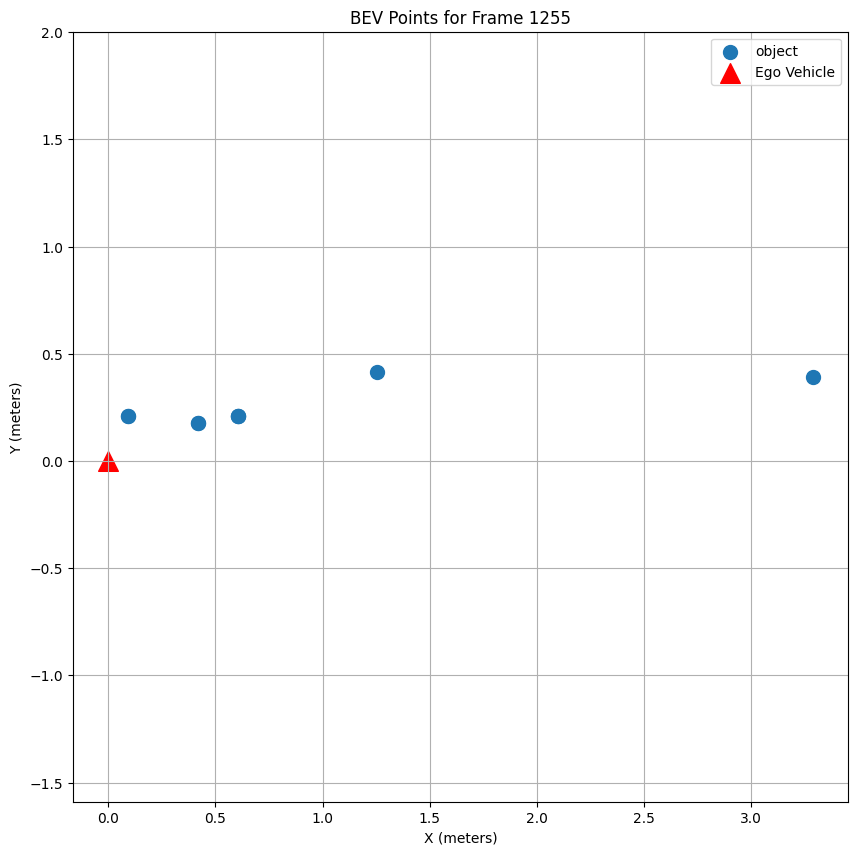

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
bev_points = pd.read_csv("/kaggle/working/CameraLidarFusion/bev_points.csv")

# Plot BEV points for the last frame (1255)
last_frame = bev_points[bev_points['frame'] == 1255]
plt.figure(figsize=(10, 10))
for source in last_frame['source'].unique():
    data = last_frame[last_frame['source'] == source]
    plt.scatter(data['x'], data['y'], label=source, s=100)
plt.scatter(0, 0, color='red', s=200, marker='^', label='Ego Vehicle')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title('BEV Points for Frame 1255')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [18]:
# Hypothetical ground truth (replace with actual data)
ground_truth_objects = [
    {'frame': 1255, 'x': 1.3, 'y': 0.4, 'class': 'car'},
    {'frame': 1255, 'x': 3.2, 'y': 0.3, 'class': 'car'}
]
detected_objects = bev_points[bev_points['source'] == 'object'][['frame', 'x', 'y']].to_dict('records')

# Compute errors
errors = []
for gt in ground_truth_objects:
    for det in detected_objects:
        if det['frame'] == gt['frame']:
            error = ((det['x'] - gt['x'])**2 + (det['y'] - gt['y'])**2)**0.5
            errors.append(error)
print(f"Average BEV point error: {np.mean(errors):.2f} meters")

Average BEV point error: 1.67 meters
